# Analysing Fluorescence Signals at all target locations

After pump down the beam source shifts slightly, causing the YAG alignment to be off.

In [1]:
import cv2
import h5py
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import find_nearest_idx
from utils.hdf_utils import load_measurement_data_devices

In [2]:
fnames = [
    '2020_3_4_rotational_cooling_microwaves',
    '2020_3_5_rotational_cooling_with_microwaves',
    'phase_modulation',
    'R0_saturation',
    'rotation_cooling',
    'rotational_cooling',
    'saturation_P2F1',
    'saturation_R0F1'
]

In [3]:
# putting all pxie and mirror data from the files specified in fnames
# into a dictionary with subdictionaries, organized by fname -> dset_name -> (pxie, pxie_time, mirror)
pxie_data = {}
for fname in tqdm(fnames):
    pxie_data[fname] = {}
    with h5py.File(fname+'.hdf', 'r') as f:
        for dset_name in f.keys():
            try:
                if len(f[dset_name]['readout']['PXIe-5171'].keys()) > 100:
                    pxie_data[fname][dset_name] = load_measurement_data_devices(fname+'.hdf', dset_name, devices = ('ZaberTMM',))
            except:
                pass

In [4]:
# for each pxie trace grab closest mirror coordinates

pmt = 1 # pmt channel

coords_signals = {}
for fname, data in pxie_data.items():
    coord_cnts = 0
    for dset_name, run_data in data.items():
        pxie = run_data[0]
        pxie_time = run_data[1]
        mirror = run_data[2]['ZaberTMM']
        idx_pairs = {idx_pxie: find_nearest_idx(mirror['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
        for idx_pxie, idx_mirror in idx_pairs.items():
            coords = (mirror['x'][idx_mirror], mirror['y'][idx_mirror])
            if coords_signals.get(coords, None):
                coords_signals[coords].append(pxie[idx_pxie][:,pmt])
            else:
                coords_signals[coords] = [pxie[idx_pxie][:,pmt]]

In [5]:
# process pxie traces to get the mean and integral for each mirror coordinate

coords_signals_processed = {}
for key, value in coords_signals.items():
    # mean of all traces at same coordinate
    mean = np.mean([val - np.mean(val[50:250]) for val in value], axis = 0)
    # savgol filter of the mean, for ease of visual inspection
    filtered = savgol_filter(mean, window_length = 101, polyorder = 1)
    # integral of mean
    integral = np.trapz(-filtered[250:1900])
    coords_signals_processed[key] = (-mean, 
                           -filtered, 
                           len(value), 
                           integral)

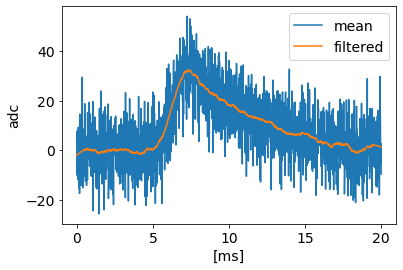

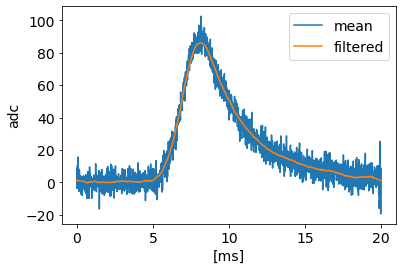

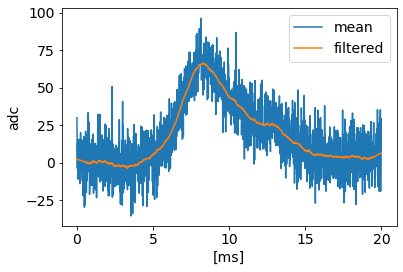

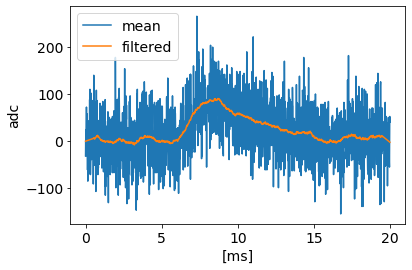

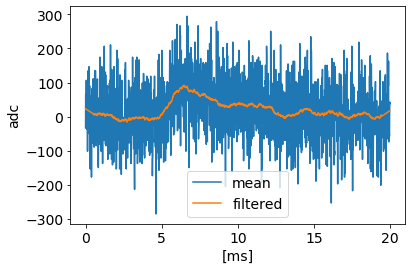

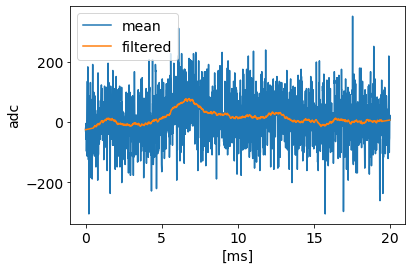

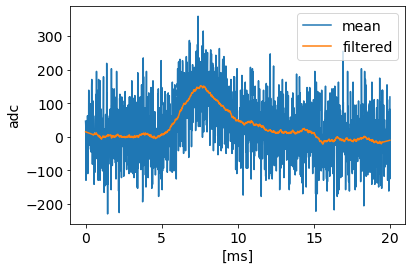

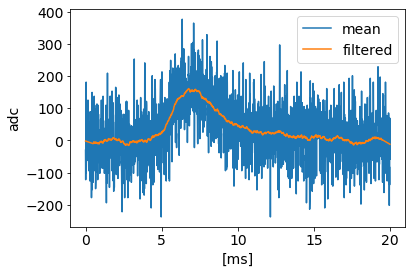

In [6]:
t = np.arange(0,20,1e-2)
for key in list(coords_signals_processed.keys())[:10]:
    value = coords_signals_processed[key]
    if value[-1] > 6000: 
        fig, ax = plt.subplots()
        ax.plot(t, value[0], label = 'mean')
        ax.plot(t, value[1], label = 'filtered')
        ax.set_xlabel('[ms]')
        ax.set_ylabel('adc')
        ax.legend(fontsize = 14)
        set_fontsize(ax, 14)

In [7]:
# x,y and z arrays for plotting the results with hexbin
x,y,C = [],[],[]
for key, value in coords_signals_processed.items():
    x.append(key[0])
    y.append(key[1])
    C.append(value[-1])
x = np.array(x)
y = np.array(y)
C = np.array(C)

mask = x < 15000
x = x[mask]
y = y[mask]
C = C[mask]

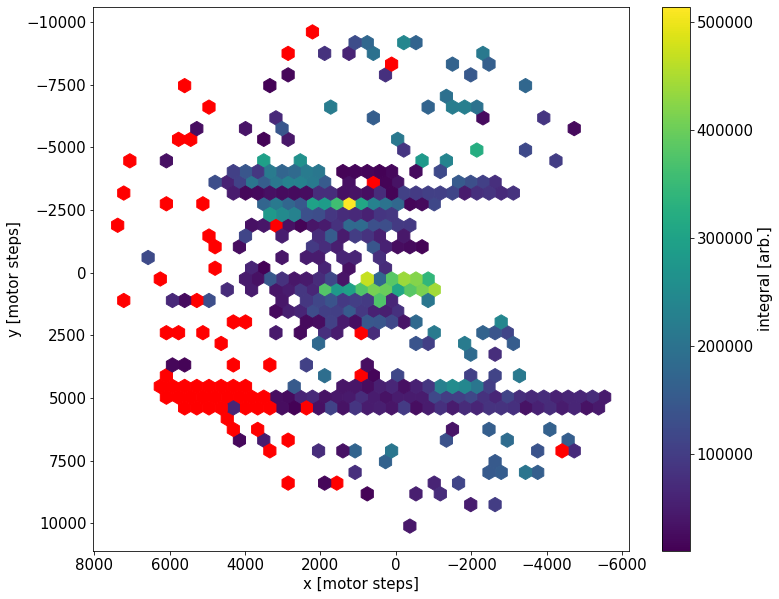

In [8]:
cmap = plt.cm.viridis
cmap.set_under(color = 'r')

fig, ax = plt.subplots(figsize = (12,10))
hb = ax.hexbin(x,y, C,vmin = 10e3, gridsize = 40, cmap = cmap)
cb = fig.colorbar(hb, ax=ax)
cb.ax.set_ylabel('integral [arb.]')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('x [motor steps]')
ax.set_ylabel('y [motor steps]')
set_fontsize(ax, 15)
set_fontsize(cb.ax, 15)

Looks everything should be moved to the right by about 2900 steps, vertical it's difficult to tell without a more complete scan

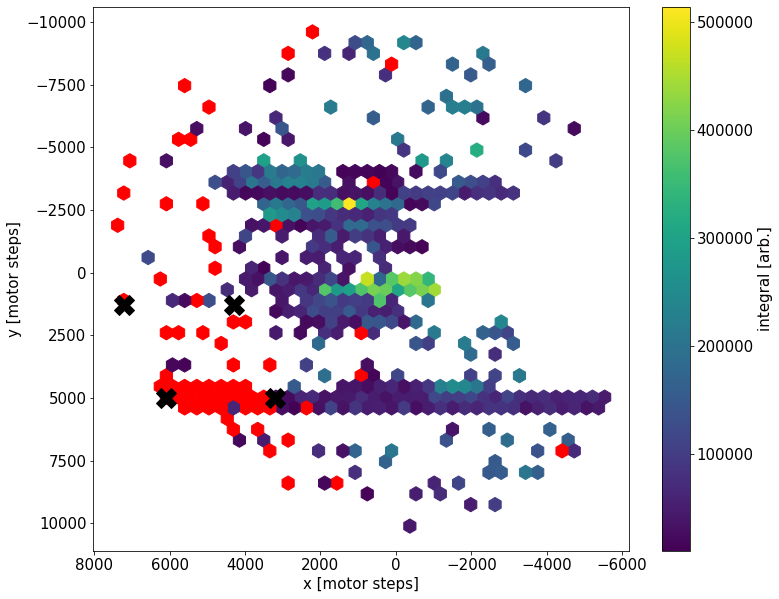

In [9]:
dx, dy = -2900, 0
fig, ax = plt.subplots(figsize = (12,10))

ax.plot(6100,5000, 'kX', ms = 20)
ax.plot(6100+dx,5000+dy, 'kX', ms = 20)

ax.plot(7200,1300, 'kX', ms = 20)
ax.plot(7200+dx,1300+dy, 'kX', ms = 20)

hb = ax.hexbin(x,y, C,vmin = 10e3, gridsize = 40, cmap = cmap)
cb = fig.colorbar(hb, ax=ax)
cb.ax.set_ylabel('integral [arb.]')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('x [motor steps]')
ax.set_ylabel('y [motor steps]')
set_fontsize(ax, 15)
set_fontsize(cb.ax, 15)

## Plotting what this looks like on a picture of the target

In [10]:
target = cv2.imread('target.jpg',1)
warp_target = cv2.imread('trace1.jpg',1)
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
warp_target = cv2.cvtColor(warp_target, cv2.COLOR_BGR2RGB)

target = cv2.resize(target, tuple(warp_target.shape[:2][::-1]))

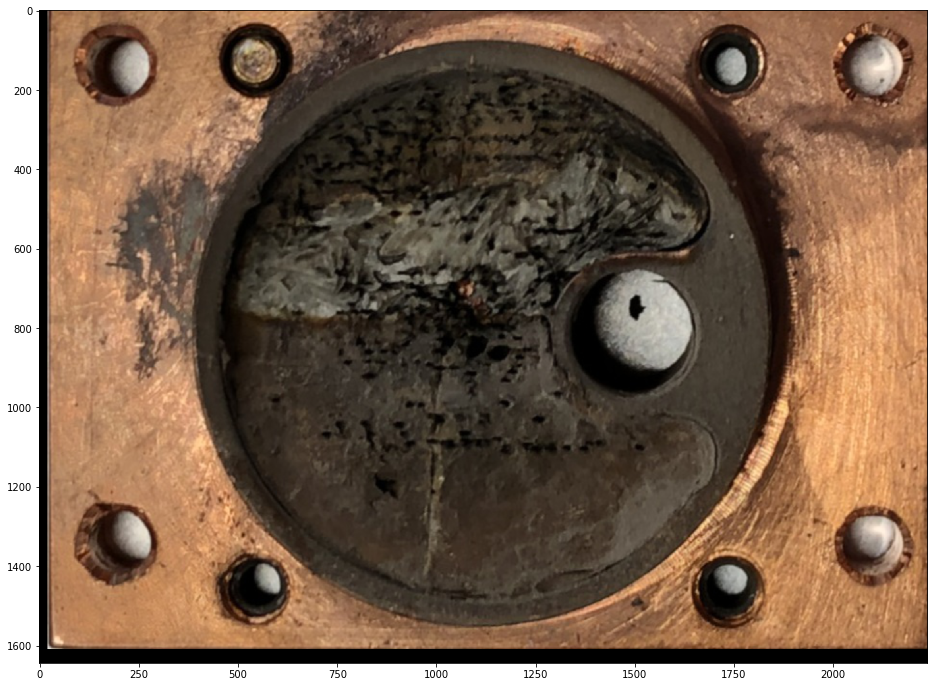

In [21]:
fig, ax = plt.subplots(figsize = (20,12))
ax.imshow(target)

### Transformations from `Steerable Mirror Translation.ipynb` in `CeNTREX-notebooks/beam source/steerable mirror/Alignment February 2020/`

In [11]:
tx = +20
ty = -35
M = np.float32([[1,0,tx],[0,1,ty]])

target = cv2.warpAffine(target, M, tuple(target.shape[:2][::-1]))

In [12]:
transform = np.array([[ 3.46095276e-01,  1.63356970e+01, -1.41374767e+04],
                      [-1.06135885e+01, -9.61375767e-01,  1.33826199e+04]])
transform_mirror_pixel = np.array([[-5.55555556e-03, -9.44000000e-02,  1.18477778e+03],
                                   [ 6.13333333e-02,  2.00000000e-03,  8.40333333e+02]])

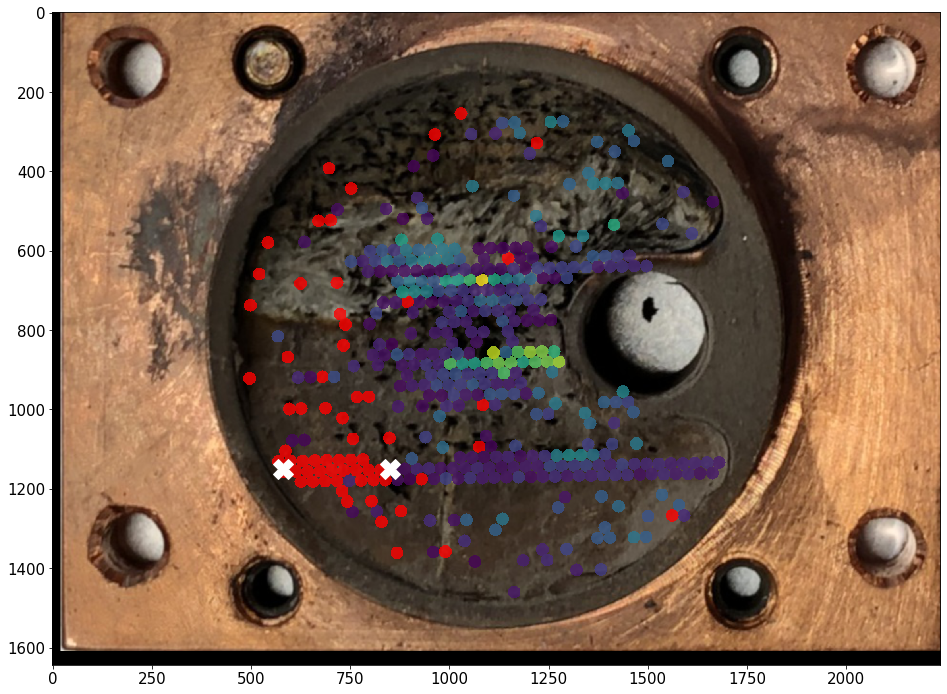

In [20]:
radius = 16
alpha = 0.8

# getting bin coordinates from the hexbin plot
verts = hb.get_offsets()
binx, biny = [],[]
for offc in range(verts.shape[0]):
    binx.append(verts[offc][0])
    biny.append(verts[offc][1])

# overlaying transparent circles with the same color scheme as hexbin
# on top of the target image
overlay = target.copy()
output = target.copy()
for xi,yi,ci in zip(binx, biny, hb.get_array()):
    pixels = np.dot(transform_mirror_pixel, [yi,xi,1]).astype(int)
    c = np.array(hb.to_rgba(ci))
    c *= 255
    c[-1] = -1
    cv2.circle(overlay, tuple(pixels), radius, color = c, thickness = -1)
    
cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

fig, ax = plt.subplots(figsize = (20,12))
ax.imshow(output)
set_fontsize(ax, 15)

dx, dy = 270, 0

ax.plot(580, 1150, 'wX', ms = 20)
ax.plot(580+dx, 1150+dy, 'wX', ms = 20)

Or move 270 pixels to the right